In [1]:
import numpy as np
from scipy.linalg import block_diag
import scipy.spatial.distance as distance
import scipy.spatial as spatial
import scipy.stats as stats
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import networkx as nx
import sklearn.manifold
import seaborn as sns
import os
import warnings
import matplotlib.patches as patches

In [7]:
class GridWorld(object):
    def __init__(self, rows=20, cols=20, rewards={(5,5):10},
                 env_type=None, rho=0.0, step_penalization=-0.01,
                 terminals=None, obstacles=None, jumps=None,
                 port_shift=None, barheight=None,
                 around_reward=False,
                 **kwargs):
        '''
        :param rows (int): specifying width (x dim) of grid
        :param cols (int): specifying height (y dim) of grid
        :param rewards (dict): reward location coordinates as keys and reward magnitude as values

        :param env_type (str): [None, 'bar','room','tmaze', 'triple_reward']
        :param rho (float): density of obstacles to be randomly positioned in environment
        :param step_penalization (float): penalization for each step (small negative reward)

        :param terminals (list): terminal state coordinates
        :param obstacles (list): obstacle coordinates
        :param jumps (dict): keys and values are coordinates in the environment (x,y):(w,z)
                             where agent can select jump action in coordinate (x,y) and moves to coordinate (w,z)

        :param port_shift (str):  ['equal', 'left', 'right']: type of probability distribution for Kirth's task
        :param barheight (int): height of horizontal line of obstacles dividing the plane

        :param around_reward (bool): whether to randomly choose agent starting location around reward location
        '''
        self.shape = (rows, cols)
        self.c = cols
        self.r = rows

        self.maze_type = env_type
        self.rho = rho

        # basic set up states, rewards
        self.nstates = self.c*self.r
        self.rewards = rewards

        # populate list of obstacles
        self.obstacles_list = obstacles

        if self.maze_type == 'bar':
            if barheight is not None:
                self.barheight 	= barheight
        self.grid, self.useable, self.obstacles_list = self.buildGrid()

        # populate list of terminals
        if terminals is not None:
            if isinstance(terminals, tuple):
                self.terminal2D = [terminals]
                self.terminal = [self.twoD2oneD(terminals)]
            else:
                self.terminal2D = terminals
                self.terminal = [self.twoD2oneD((r,c)) for r,c in terminals]
        else:
            self.terminal2D = []
            self.terminal = []

        # populate list of jump states
        if jumps is not None:
            self.jump = jumps
            self.jump_from = [self.twoD2oneD((r,c)) for r,c in list(jumps.keys())]
            self.jump_to = [self.twoD2oneD((r,c)) for r,c in list(jumps.values())]
        else:
            self.jump = None
            self.jump_from = []
            self.jump_to = []

        # Actions
        self.action_list    = kwargs.get('actionlist', ['Down', 'Up', 'Right', 'Left', 'Jump', 'Poke'])
        self.action_dict    = kwargs.get('actiondict', {x: ind for ind, x in enumerate([x[0] for x in self.action_list])})
        self.nactions       = len(self.action_list)
        self.buildTransitionMatrix()

        # Reward
        self.finish_after_first_reward = kwargs.get('finish_after_first_reward',True)
        if self.finish_after_first_reward:
            # add reward location to list of terminal states
            for r,c in self.rewards.keys():
                self.terminal2D.append((r,c))
                self.terminal.append(self.twoD2oneD((r, c)))
        self.rwd_action = kwargs.get('rewarded_action', 'Poke')
        self.step_penalization = step_penalization
        self.buildRewardFunction()

        # additional features from specific environment types
        if self.maze_type == 'tmaze':
            if port_shift is not None:
                self.port_shift	= port_shift
            else:
                self.port_shift = 'none'
        if self.maze_type == 'triple_reward':
            self.rwd_loc 		= [(self.r-1, 0), (self.r-1, self.c-1), (0, self.c-1)]
            self.orig_rwd_loc 	= [(self.r-1, 0), (self.r-1, self.c-1), (0, self.c-1)]
            self.starter 		= kwargs.get('t_r_start', (0,0))
            self.start_loc      = self.starter

        self.random_start = kwargs.get('random_start',True)
        self.reset()
        
        self.view = True
        if self.view:
            view_labels = kwargs.get('view_labels',False)
            self.reset_viewer(states=view_labels)
            self.viewer = self.figure[0].canvas

    def oneD2twoD(self, idx):
        return (int(idx / self.shape[1]),np.mod(idx,self.shape[1]))

    def twoD2oneD(self, coord_tuple):
        r,c = coord_tuple
        return (r * self.shape[1]) + c

    def buildGrid(self, bound=False): #formerly grid_maker()
        env_types = [None, 'bar','room','tmaze', 'triple_reward']

        if self.maze_type not in env_types:
            raise Exception(f"Environment Type '{self.maze_type}' Not Recognized. \nOptions are: {env_types} \nDefault is Open Field (maze_type = 'none')")

        grid = np.zeros((self.r,self.c), dtype=int)

        # set up obstables for different grid types
        if self.maze_type == 'bar':
            space = 2
            self.rho = 0
            for i in range(self.c-(2*space)):
                grid[self.barheight][i+space] = 1

        elif self.maze_type == 'room':
            self.rho = 0
            vwall = int(self.c/2)
            hwall = int(self.r/2)

            #make walls
            for i in range(self.c):
                grid[vwall][i] = 1
            for i in range(self.r):
                grid[i][hwall] = 1

            # make doors
            self.doors = []
            self.doors.append((vwall, np.random.choice(np.arange(0,vwall))))
            self.doors.append((vwall, np.random.choice(np.arange(vwall+1, self.c))))

            self.doors.append((np.random.choice(np.arange(0,hwall)), hwall))
            self.doors.append((np.random.choice(np.arange(hwall+1, self.r)),hwall))
            for i in self.doors:
                grid[i] = 0

        elif self.maze_type == 'tmaze':
            self.rho = 0
            self.possible_ports = []
            grid = np.ones((self.r, self.c), dtype=int)
            h1, v1 = int(self.c/2), 0
            if h1%2==0:
                for i in range(self.c):
                    grid[v1][i] = 0
                    if i == 0:
                        self.possible_ports.append((i,v1))
                    elif i == self.c-1:
                        self.possible_ports.append((i,v1))
            else:
                for i in range(self.c):
                    grid[v1][i] = 0
                    if i == 0:
                        self.possible_ports.append((i,v1))
                    elif i == self.c-1:
                        self.possible_ports.append((i,v1))

            if self.r > int(self.c/2):
                for i in range(self.r):
                    grid[i][h1] = 0
                    if i == self.r-1:
                        self.possible_ports.append((h1,i))
            else:
                for i in range(self.r):
                    grid[i][h1] = 0
                    if i == self.r-1:
                        self.possible_ports.append((h1,i))

        if self.obstacles_list is None:
            if self.rho != 0:
                maze = np.vstack([[np.random.choice([0,1], p = [1-self.rho, self.rho]) for _ in range(self.c)] for _ in range(self.r)])
                grid = grid + maze
                for reward_loc in self.rewards:
                    if grid[reward_loc[1], reward_loc[0]] == 1:
                        grid[reward_loc[1], reward_loc[0]] = 0

            obstacles = list(zip(np.where(grid==1)[0], np.where(grid==1)[1]))
            self.obstacle2D = obstacles
            self.obstacle = [self.twoD2oneD((r,c)) for r,c in obstacles]

        else:
            for reward_loc in self.rewards:
                if reward_loc in self.obstacles_list:
                    self.obstacles_list.remove(reward_loc)
            if isinstance(self.obstacles_list, tuple):
                self.obstacle2D = [self.obstacles_list]
                self.obstacle = [self.twoD2oneD(self.obstacles_list)]
            else:
                self.obstacle2D = self.obstacles_list
                self.obstacle = [self.twoD2oneD((r,c)) for r,c in self.obstacles_list]
                for coord in self.obstacles_list:
                    grid[coord] = 1

        if bound:
            grid_bound = np.ones((self.r+2, self.c+2), dtype=int)
            grid_bound[1:-1][:,1:-1] = grid
            grid = grid_bound

        # lists of tuples storing locations of open grid space and obstacles (unusable grid space)
        useable_grid = list(zip(np.where(grid==0)[0], np.where(grid==0)[1]))
        obstacles = list(zip(np.where(grid==1)[0], np.where(grid==1)[1]))

        return grid, useable_grid, obstacles

    def buildRewardFunction(self):
        if self.rwd_action in self.action_list:
            self.R = self.step_penalization*np.ones((self.nstates, len(self.action_list)))
            action = self.action_list.index(self.rwd_action)
            for r,c in list(self.rewards.keys()):
                self.R[self.twoD2oneD((r,c)), action] = self.rewards[(r,c)]
        else:
            # specify reward function
            self.R = self.step_penalization*np.ones((self.nstates,))  # rewards received upon leaving state
            for r,c in list(self.rewards.keys()):
                self.R[self.twoD2oneD((r,c))] = self.rewards[(r,c)]

    def buildTransitionMatrix(self):
        # initialize
        self.P = np.zeros((len(self.action_list), self.nstates, self.nstates))  # down, up, right, left, jump, poke

        # add neighbor connections and jumps, remove for endlines
        self.P[0, list(range(0, self.nstates-self.shape[1])), list(range(self.shape[1], self.nstates))] = 1     # down
        self.P[1, list(range(self.shape[1], self.nstates)), list(range(0, self.nstates-self.shape[1]))] = 1  	# up

        self.P[2, list(range(0, self.nstates-1)), list(range(1, self.nstates))] = 1  							# right
        self.P[3, list(range(1, self.nstates)), list(range(0, self.nstates-1))] = 1  							# left
        if len(self.action_list) > 4:
            self.P[4, self.jump_from, self.jump_to] = 1												# jump

        # remove select states
        endlines = list(range(self.shape[1]-1,self.nstates-self.shape[1],self.shape[1]))
        endlines2 = [x+1 for x in endlines]
        self.P[2, endlines, endlines2] = 0	# remove transitions at the end of the grid
        self.P[3, endlines2, endlines] = 0
        for i in range(4):
            self.P[i, :, self.obstacle] = 0  	# remove transitions into obstacles
            self.P[i, self.obstacle, :] = 0  	# remove transitions from obstacles
            self.P[i, self.terminal, :] = 0  	# remove transitions from terminal states
            if len(self.action_list) >4:
                self.P[i, self.jump_from, :] = 0 	# remove neighbor transitions from jump states

        if len(self.action_list) >5:
            # poke should make no transitions between states so everything stays 0
            self.P[5, list(range(0, self.nstates)), list(range(0, self.nstates))] = 1

    def remapTransitionMatrix(self):
        oldP = self.P

        # initalize
        self.P = np.zeros((len(self.action_list), self.nstates, self.nstates))  # down, up, right, left, jump, poke

        for x in range(oldP.shape[0]):
            col = (x + 1) % oldP.shape[0]
            self.P[col, :, :] = oldP[x, :, :]

        print("transition probabilities remapped")

    def get_random_start_location(self):
        get_start = np.random.choice(len(self.useable))
        start_r = self.useable[get_start][0]
        start_c = self.useable[get_start][1]
        return (start_r, start_c)

    def get_start_location(self, around_reward, **kwargs):
        if around_reward:
            radius = kwargs.get('rad', 5)
            # pick starting location for agent in radius around reward location
            start_buffer = radius  # radius around reward
            starting_reward = list(self.rewards.keys())[np.random.choice(np.arange(len(self.rewards.keys())))]
            get_start_loc = True
            while get_start_loc:
                buf_r = np.random.choice(np.arange(start_buffer))
                start_r = starting_reward[0] + np.random.choice([-1, 1])*buf_r
                if start_r < 0:
                    start_r = 0
                elif start_r > self.grid.shape[0] - 1:
                    start_r = self.grid.shape[0] - 1

                buf_c = np.random.choice(np.arange(start_buffer))
                start_c = starting_reward[1] + np.random.choice([-1, 1])*buf_c
                if start_c < 0:
                    start_c = 0
                elif start_c > self.grid.shape[1] - 1:
                    start_c = self.grid.shape[1] - 1
                if (start_r, start_c) in self.useable:
                    get_start_loc = False
        else: # pick a random starting location for agent within the useable spaces
            get_start = np.random.choice(len(self.useable))
            start_r = self.useable[get_start][0]
            start_c = self.useable[get_start][1]

        start_coord = (start_r, start_c)

        return start_coord

    def set_state(self, state):
        self.state = state

    def get_state(self):
        return self.state

    def get_actions(self):
        slice_n_dice = self.P[:,self.state,:]
        return np.any(slice_n_dice,axis=1)

    def set_reward(self, rewards):
        self.rewards = rewards

        # recalculate reward function
        self.buildRewardFunction()

    def get_reward(self, action):
        action = self.action_list[action][0]
        if len(self.R.shape) > 1:
            reward = self.R[self.state,self.action_dict[action]]
        else:
            reward = self.R[self.state]
        if self.finish_after_first_reward and reward in self.rewards.values():
            self.done = True
        
        # check if this is a terminal state
        if self.state in self.terminal:
            self.done = True

        # TODO: fix for kirth
        if self.maze_type == 'tmaze':
            if self.port_shift in ['equal', 'left', 'right']:
                self.shift_rwd(self.port_shift)

        return reward
    
    def reset_viewer(self, **kwargs):
        trial = kwargs.get('trial', 'Grid World')
        states = kwargs.get('states',False)
        self.figure = plot_world(self, title=f'Trial {trial}',states=states)
        ## test
        fig, ax = self.figure
        agent_r, agent_c = self.oneD2twoD(self.state)
        patch = patches.Circle((agent_c + .5, agent_r + .5), 0.35,
                               fc='b')  ## plot functions use x,y we use row(y), col(x)
        ax.add_patch(patch)
        fig.canvas.draw()
        plt.show(block=False)
        ## /test
        
    def render(self, pause_time=0.01, mode='human', **kwargs):
        trial = kwargs.get('trial', None)
        if mode == 'human':
            agent_r, agent_c = self.oneD2twoD(self.state)
            self.figure[1].patches[1].set_center([agent_r + 0.5, agent_c + 0.5])
            self.figure[0].canvas.draw()
            plt.pause(pause_time)

            # TODO: fix this so render just updates the current_state patch
            # TODO: base object to write current_state patch on top of
        else:
            assert 0, "Render mode '%s' is not supported" %mode

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

    def reset(self):
        if self.random_start:
            self.start = self.get_random_start_location()
        else:
            self.start = self.useable[0]
        self.state = self.twoD2oneD(self.start)

        self.done = False

        return self.state

    def step(self, action):
        """
        Args:
            move (str): one of ['D','U','R','L','J'] for down, up, right, left, and jump, respectively.
        Returns:
            tuple (a,b,c,d): a is the new state, b is the reward value, and c is a bool signifying terminal state, d is an empty dictionary to conform with OpenAi gym step function returning an 'info' parameter
        """

        # check if move is valid, and then move
        x = self.get_actions()
        if not self.get_actions()[action]:
            #raise Exception('Agent has tried an invalid action!')
            pass
        else:
            transition_probs = self.P[action, self.state,:]
            self.state = np.nonzero(transition_probs)[0][0]  # update to new state

        reward = self.get_reward(action) ## self.done is set in this function

        is_terminal = self.done

        return self.state, reward, is_terminal, {}
    
def plot_world(world, **kwargs):
    scale = kwargs.get('scale', 0.35)
    title = kwargs.get('title', 'Grid World')
    ax_labels = kwargs.get('ax_labels', False)
    state_labels = kwargs.get('states', False)
    invert_ = kwargs.get('invert', False)
    if invert_:
        cmap = 'bone'
    else:
        cmap = 'bone_r'
    r,c = world.shape

    fig = plt.figure(figsize=(c*scale, r*scale))
    ax = fig.add_subplot(1,1,1)

    gridMat = np.zeros(world.shape)
    for i, j in world.obstacle2D:
        gridMat[i, j] = 1.0
    for i, j in world.terminal2D:
        gridMat[i, j] = 0.2
    ax.pcolor(gridMat, edgecolors='k', linewidths=0.75, cmap=cmap, vmin=0, vmax=1)

    U = np.zeros((r, c))
    V = np.zeros((r, c))
    U[:] = np.nan
    V[:] = np.nan

    if len(world.action_list) >4 :
        if world.jump is not None:
            for (a, b) in world.jump.keys():
                (a2, b2) = world.jump[(a, b)]
                U[a, b] = (b2 - b)
                V[a, b] = (a - a2)

    C, R = np.meshgrid(np.arange(0, c) + 0.5, np.arange(0, r) + 0.5)
    ax.quiver(C, R, U, V, scale=1, units='xy')

    for rwd_loc in world.rewards.keys():
        rwd_r, rwd_c = rwd_loc
        if world.rewards[rwd_loc] < 0:
            colorcode = 'red'
        else:
            colorcode = 'darkgreen'
        ax.add_patch(plt.Rectangle((rwd_c, rwd_r), width=1, height=1, linewidth=2, facecolor=colorcode, alpha=0.5))

    if state_labels:
        for (i,j) in world.useable:
            # i = row, j = col
            ax.text(j+0.5,i+0.7, s=f'{world.twoD2oneD((i,j))}', ha='center')


    #ax.set_xticks([np.arange(c) + 0.5, np.arange(c)])
    #ax.set_yticks([np.arange(r) + 0.5, np.arange(r)])
    ax.invert_yaxis()
    ax.set_aspect('equal')
    if not ax_labels:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    ax.set_title(title)

    return fig, ax


class GridWorld_4rooms(GridWorld):
    def __init__(self):
        self.action_list = ['Down', 'Up', 'Right', 'Left']
        self.rewarded_action = None
        self.obstacles_list = [(0, 10), (1, 10), (2, 10), (3, 10), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10), (10, 0), (10, 1), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (10, 16), (10, 17), (10, 18), (10, 19), (11, 10), (12, 10), (14, 10), (15, 10), (16, 10), (17, 10), (18, 10), (19, 10)]
        super().__init__(actionlist=self.action_list, rewarded_action=self.rewarded_action,obstacles=self.obstacles_list)

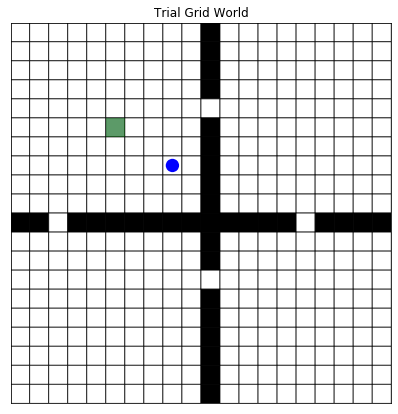

In [8]:
gw_4rooms = GridWorld_4rooms()